# Rule: **add_electricity**

**Summary** (from *add_electricity.py*)

Adds electrical generators and existing hydro storage units to a base network.

**Outputs**

- resources/networks/`elec.nc`


**Description** (from *add_electricity.py*)

This rule ties all the different data inputs from the preceding rules together into a detailed PyPSA network. It includes:

- today's transmission topology and transfer capacities (optionally including lines which are under construction according to the config settings ``lines: under_construction`` and ``links: under_construction``),
- today's thermal and hydro power generation capacities (for the technologies listed in the config setting ``electricity: conventional_carriers``), and
- today's load time-series (upsampled in a top-down approach according to population and gross domestic product)

It further adds extendable ``generators`` with **zero** capacity for

- photovoltaic, onshore and AC- as well as DC-connected offshore wind installations with today's locational, hourly wind and solar capacity factors (but **no** current capacities),
- additional open- and combined-cycle gas turbines (if ``OCGT`` and/or ``CCGT`` is listed in the config setting ``electricity: extendable_carriers``)


**Comments:**

- Two generators of the same carrier (e.g. CCGT) may coexist at the same bus, one with imported capacity, and other with zero capacity due to "everywhere".

- Capital costs for offwind-ac, offwind-dc and offwind-floating generators are different at each node according to grid connection costs (different distance).

- Note that capital costs assigned to generators are annualised [EUR/MW·year], while the capital costs in *costs.csv* are for the whole lifetime [EUR/kW].

- However, note that cost data are overwritten later at `prepare_sector_network` (TO CHECK)

In [48]:
import pypsa
import pandas as pd
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import yaml
import os 
import sys


##### Local funs
funs_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'local_funs'))
sys.path.append(funs_path)

from fun_map_add_features import fun_map_add_features

from fun_map_network_geometry import fun_map_network_geometry
from fun_map_network_generators import fun_map_network_generators
from fun_map_network_loads import fun_map_network_loads
from fun_map_network_storage_units import fun_map_network_storage_units

from fun_map_NUTS_geometry import fun_map_NUTS_geometry
from fun_map_NUTS_generators import fun_map_NUTS_generators
from fun_map_NUTS_loads import fun_map_NUTS_loads
from fun_map_NUTS_storage_units import fun_map_NUTS_storage_units




##### Warnings setup
import warnings
warnings.filterwarnings('ignore', category=UserWarning)



In [49]:
######################################## Parameters

##### Read config file
with open('../config.yaml', 'r') as configfile:
    config = yaml.safe_load(configfile)

# Unwrap variables 
rootpath = config['notebook']['rootpath']
prefix = config['notebook']['prefix']
name = config['notebook']['name']

boundaries_onshore = config['map']['boundaries_onshore']
boundaries_offshore = config['map']['boundaries_offshore']

## `elec.nc`

Load the network and show components.

In [50]:
file = f'elec.nc'
path = f'{rootpath}/resources/{prefix}/{name}/networks/'

n = pypsa.Network(path+file)

n

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, links, loads, shapes, storage_units, transformers


PyPSA Network 'PyPSA-Spain'
Components:
 - Bus: 1109
 - Carrier: 12
 - Generator: 3328
 - Line: 1474
 - Link: 1
 - Load: 522
 - Shape: 1096
 - StorageUnit: 109
 - Transformer: 84
Snapshots: 8760

Plot the network.

Text(0.5, 1.0, 'elec.nc')

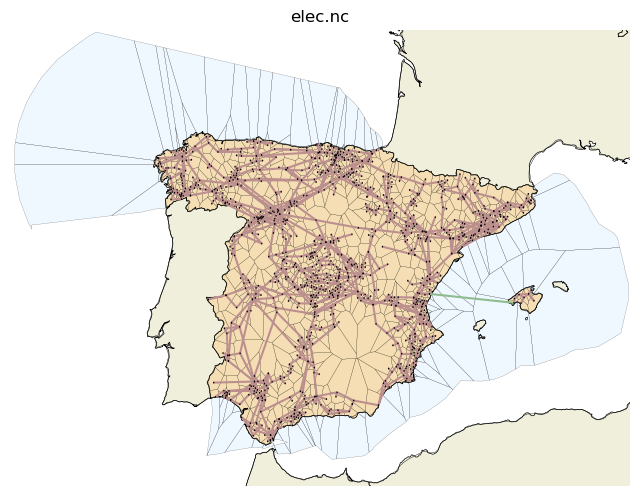

In [51]:
#################### Parameters
bus_sizes = 0.0005
bus_colors = 'black'



#################### Plot map

fig_size = [8,12]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network
n.plot(ax=ax, bus_sizes=bus_sizes, bus_colors=bus_colors, boundaries=boundaries_offshore)

### Add network geometry
fun_map_network_geometry(n, ax, domain='both')

### Add features
fun_map_add_features(ax)


ax.set_title('elec.nc')

### Variable: `n.carriers`

Show the carriers.

In [52]:
n.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
AC,0.000,#70af1d,AC,inf,0.0
DC,0.000,#8a1caf,DC,inf,0.0
CCGT,0.198,#a85522,Combined-Cycle Gas,inf,0.0
nuclear,0.000,#ff8c00,nuclear,inf,0.0
onwind,0.000,#235ebc,Onshore Wind,inf,0.0
solar,0.000,#f9d002,Solar,inf,0.0
offwind-float,0.000,#b5e2fa,Offshore Wind (Floating),inf,0.0
hydro,0.000,#298c81,Reservoir & Dam,inf,0.0
solar-hsat,0.000,#fdb915,solar-hsat,inf,0.0


### Variable: `n.generators`

Store `n.generators` in a dataFrame.

In [53]:
gg = n.generators

#### Summary

Make a summary table with capacity per carrier and number of entries with zero capacity


In [54]:
summary_gg = gg.groupby('carrier').agg(
    Total_capacity=pd.NamedAgg(column='p_nom', aggfunc='sum'),
    Buses=pd.NamedAgg(column='p_nom', aggfunc='size'),
    Buses_zero_capacity=pd.NamedAgg(column='p_nom', aggfunc=lambda x: (x == 0).sum()),
    Buses_non_zero_capacity=pd.NamedAgg(column='p_nom', aggfunc=lambda x: (x != 0).sum()),
).reset_index()

summary_gg

,carrier,Total_capacity,Buses,Buses_zero_capacity,Buses_non_zero_capacity
0,CCGT,23432.532000,52,0,52
1,nuclear,3112.600000,3,0,3
2,offwind-float,2.941728,102,89,13
3,onwind,26813.722162,989,13,976
4,ror,277.008247,210,0,210
5,solar,10135.023624,986,13,973
6,solar-hsat,0.000000,986,986,0


#### Maps

Plot a map showing a specific feature of a carrier at each Voronoi cell.

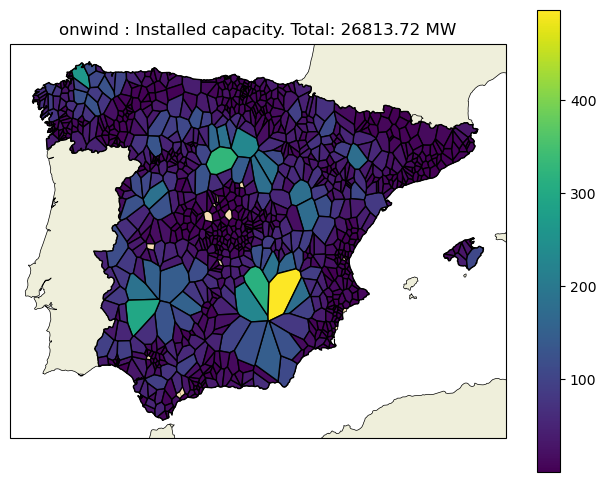

In [55]:
#################### Parameters

##### Select carrier
carrier = 'onwind'

##### Select feature. Uncomment one of the following:
# feature = 'area' 
feature = 'p_nom'
# feature = 'p_nom_density'
# feature = 'p_nom_max'
# feature = 'p_nom_max_density'
# feature = 'p_nom_max_ratio'



#################### Derived parameters
if 'off' in carrier:
    domain = 'offshore'
else:
    domain = 'onshore'



#################### Plot map

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_network_geometry(n, ax, domain)

### Add network capacity at Voronoi cells
fun_map_network_generators(carrier, n, feature, ax)

### Add features
fun_map_add_features(ax)




Plot the same but aggregated to a specific NUTS level.

(For **PyPSA-Spain**, you can use NUTS files stored in folder `data_ES/`).

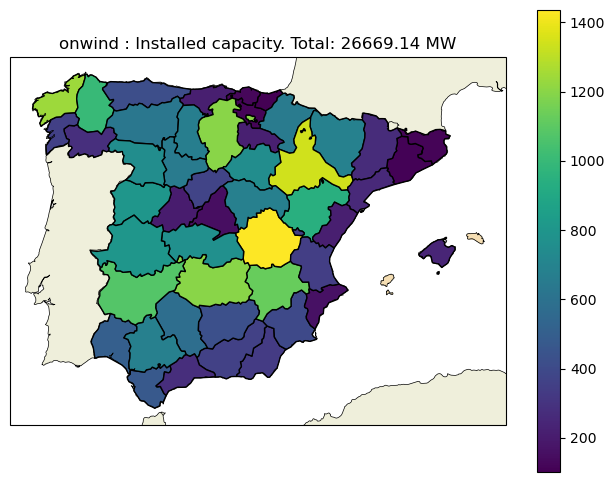

In [56]:
#################### Parameters

##### Select carrier
carrier = 'onwind'

##### Select feature. Uncomment one of the following:
# feature = 'area_NUTS' 
feature = 'weighted_p_nom'
#feature = 'weighted_p_nom_density'
#feature = 'weighted_p_nom_max'
#feature = 'weighted_p_nom_max_density'
#feature = 'weighted_p_nom_max_ratio'


##### Retrieve gdf_NUTS (it must contain at least columns 'NUTS_ID' and 'geometry')
NUTS_level = '3' 

file_NUTS = f'NUTS{NUTS_level}_ES.geojson'
path_NUTS = f'{rootpath}/data_ES/nuts/'
gdf_NUTS = gpd.read_file(path_NUTS+file_NUTS)

# Remove some regions
NUTS_initials_to_remove = ['ES70',   # Canary islands
                           'ES63',  # Ceuta
                           'ES64']  # Melilla

gdf_NUTS = gdf_NUTS[~gdf_NUTS['NUTS_ID'].apply(lambda x: any(x.startswith(prefijo) for prefijo in NUTS_initials_to_remove))]



#################### Plot map

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_NUTS_geometry(gdf_NUTS, ax)

### Add network capacity at NUTS regions
fun_map_NUTS_generators(carrier, n, gdf_NUTS, feature, ax)

### Add features
fun_map_add_features(ax)

#### Costs

Plot the capital costs of generation carriers.

Average capital cost for offwind-float is: 220635.87 EUR/MW·year
Capital cost for onwind is: 101644.12 EUR/MW·year
Capital cost for solar is: 38283.38 EUR/MW·year
Capital cost for solar-hsat is: 44489.52 EUR/MW·year


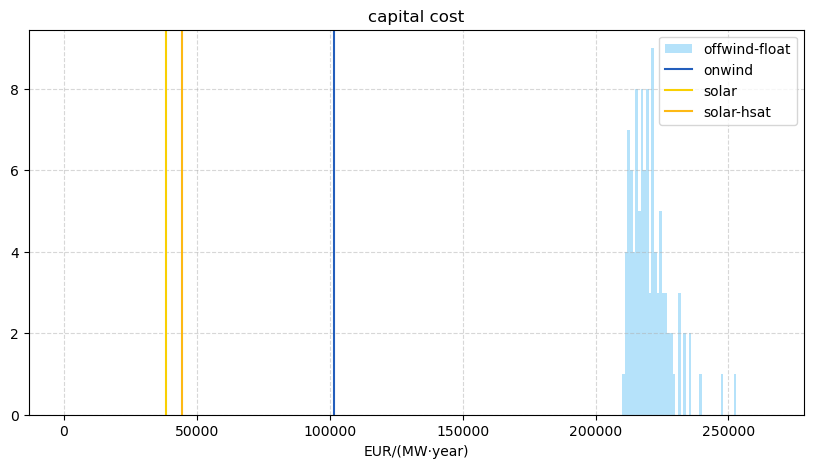

In [57]:
#################### Parameters

##### Select a list of carriers

# Get all the carriers
carrier_list = gg['carrier'].unique().tolist()

# Drop some of them
carrier_list.remove('nuclear')
carrier_list.remove('CCGT')
carrier_list.remove('ror')



#################### Make plot

fig_size = [10,5]

fig, ax = plt.subplots(1,1,figsize=fig_size)


# Define bins
minimo = 0 # 0.95 * gg.loc[ gg['carrier'].isin(carrier_list), 'capital_cost'].min()
maximo = 1.05 * gg.loc[ gg['carrier'].isin(carrier_list), 'capital_cost'].max()
ancho = 1000

bins = np.arange(minimo, maximo, 1000)


# Define colors
tech_colors = n.carriers['color']


for carrier in sorted(carrier_list):

    ##### Filter the carrier
    df = gg[gg['carrier']==carrier]


    ##### Only single cost for the carrier
    if df['capital_cost'].round(2).nunique()==1:

        valor = df['capital_cost'].unique()[0]

        ax.axvline(x=valor, label=carrier, color = tech_colors[carrier])

        print(f'Capital cost for {carrier} is: {valor:.2f} EUR/MW·year')

    ##### Different costs for the carrier
    else:
        plt.hist(df['capital_cost'], bins=bins, 
                 edgecolor='none', color = tech_colors[carrier],
                 label=carrier, alpha=1)
        
        valor = df['capital_cost'].mean()
        print(f'Average capital cost for {carrier} is: {valor:.2f} EUR/MW·year')


ax.set_title('capital cost')
ax.set_xlabel('EUR/(MW·year)')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

### Variable: `n.loads_t`

Store `n.loads_t` in a dataFrame.

In [58]:
lo_t = n.loads_t['p_set']

#### Time series

Plot some load time series. An important question is wether or not the same profile is employed for each Voronoi cell (taken from national load time series) or not (as in `PyPSA-Spain`).

Text(0, 0.5, 'MW')

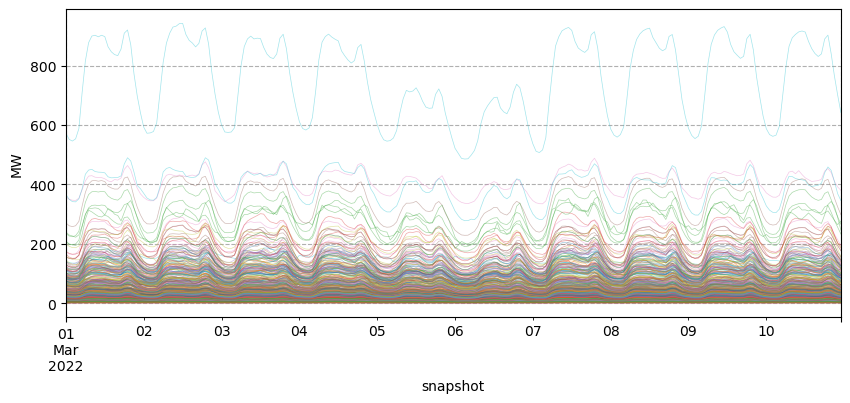

In [59]:
#################### Parameters
initial_snapshot = '2022-03-01'
final_snapshot = '2022-03-10'



#################### Make plot

fig_size = [10,4]

fig, ax = plt.subplots(figsize=fig_size)

lo_t.loc[initial_snapshot:final_snapshot].plot(ax=ax, alpha=.4, legend=False, linewidth=.5)

ax.grid(True, linestyle='--', alpha=1)
ax.set_ylabel('MW')

#### Maps

Plot a map showing a specific feature of the load at each Voronoi cell.

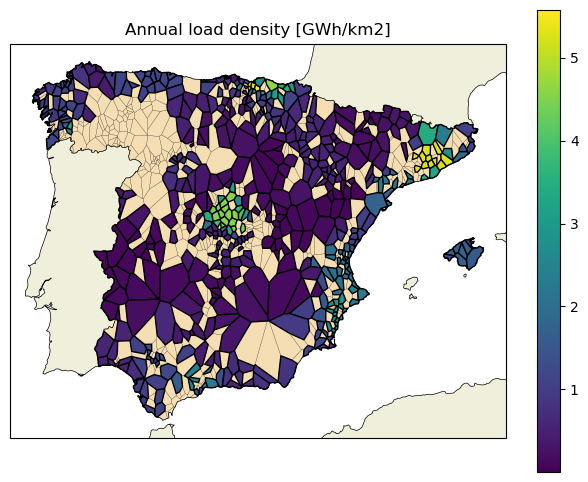

In [60]:
#################### Parameters

##### Select feature. Uncomment one of the following:
# feature = 'area' 
# feature = 'annual_load'
feature = 'annual_load_density'



#################### Plot map

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_network_geometry(n, ax, 'onshore')

### Add network capacity at Voronoi cells
fun_map_network_loads(n, feature, ax)

### Add features
fun_map_add_features(ax)




Plot the same but aggregated to a specific NUTS level.

(For **PyPSA-Spain**, you can use NUTS files stored in folder `data_ES/`).

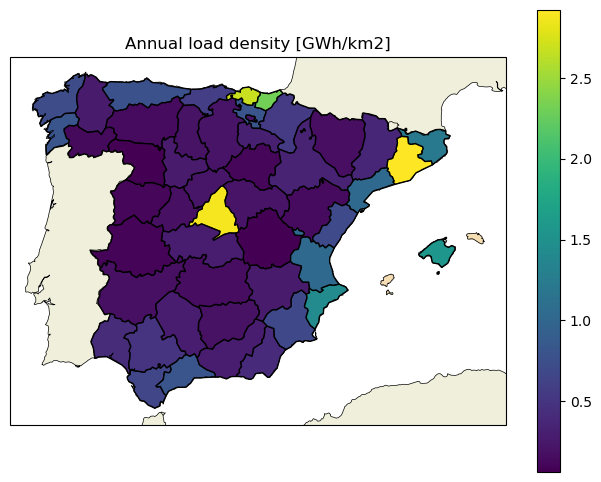

In [61]:
#################### Parameters

##### Select feature. Uncomment one of the following:
# feature = 'area_NUTS' 
# feature = 'weighted_annual_load'
feature = 'weighted_annual_load_density'


##### Retrieve gdf_NUTS (it must contain at least columns 'NUTS_ID' and 'geometry')
NUTS_level = '3' 

file_NUTS = f'NUTS{NUTS_level}_ES.geojson'
path_NUTS = f'{rootpath}/data_ES/nuts/'
gdf_NUTS = gpd.read_file(path_NUTS+file_NUTS)

# Remove some regions
NUTS_initials_to_remove = ['ES70',   # Canary islands
                           'ES63',  # Ceuta
                           'ES64']  # Melilla

gdf_NUTS = gdf_NUTS[~gdf_NUTS['NUTS_ID'].apply(lambda x: any(x.startswith(prefijo) for prefijo in NUTS_initials_to_remove))]



#################### Plot map

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_NUTS_geometry(gdf_NUTS, ax)

### Add network capacity at NUTS regions
fun_map_NUTS_loads(n, gdf_NUTS, feature, ax)

### Add features
fun_map_add_features(ax)

### Variable: `n.storage_units`

Store `n.storage_units` in a dataFrame.

In [62]:
su = n.storage_units

#### Summary

Make a summary table with capacity per carrier and number of entries with zero capacity


In [63]:
summary_su = su.groupby('carrier').agg(
    Total_capacity=pd.NamedAgg(column='p_nom', aggfunc='sum'),
    Buses=pd.NamedAgg(column='p_nom', aggfunc='size'),
    Buses_zero_capacity=pd.NamedAgg(column='p_nom', aggfunc=lambda x: (x == 0).sum()),
    Buses_non_zero_capacity=pd.NamedAgg(column='p_nom', aggfunc=lambda x: (x != 0).sum()),
).reset_index()

summary_su

,carrier,Total_capacity,Buses,Buses_zero_capacity,Buses_non_zero_capacity
0,PHS,8870.750,18,0,18
1,hydro,14974.337,91,0,91


#### Maps

Plot a map showing a specific feature of a carrier at each Voronoi cell.

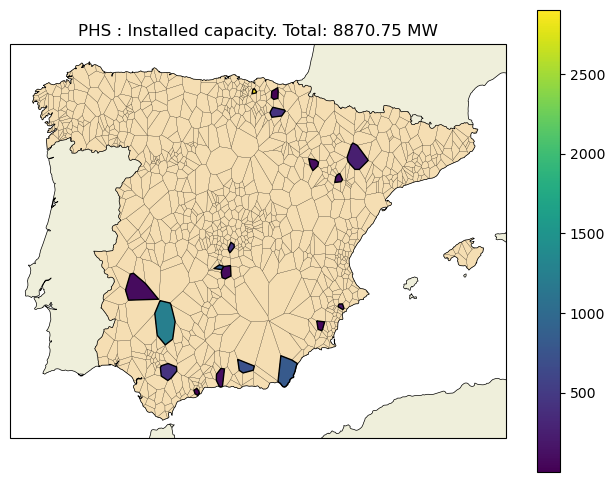

In [68]:
#################### Parameters

##### Select carrier
carrier = 'PHS'

##### Select feature. Uncomment one of the following:
# feature = 'area' 
feature = 'p_nom'
# feature = 'p_nom_density'



#################### Plot map

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_network_geometry(n, ax, 'onshore')

### Add network capacity at Voronoi cells
fun_map_network_storage_units(carrier, n, feature, ax)

### Add features
fun_map_add_features(ax)




Plot the same but aggregated to a specific NUTS level.

(For **PyPSA-Spain**, you can use NUTS files stored in folder `data_ES/`).

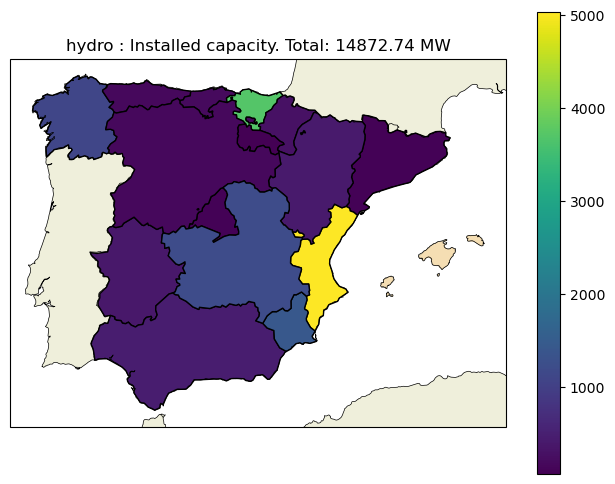

In [65]:
#################### Parameters

##### Select carrier
carrier = 'hydro'

##### Select feature. Uncomment one of the following:
# feature = 'area_NUTS' 
feature = 'weighted_p_nom'
#feature = 'weighted_p_nom_density'


##### Retrieve gdf_NUTS (it must contain at least columns 'NUTS_ID' and 'geometry')
NUTS_level = '2' 

file_NUTS = f'NUTS{NUTS_level}_ES.geojson'
path_NUTS = f'{rootpath}/data_ES/nuts/'
gdf_NUTS = gpd.read_file(path_NUTS+file_NUTS)

# Remove some regions
NUTS_initials_to_remove = ['ES70',   # Canary islands
                           'ES63',  # Ceuta
                           'ES64']  # Melilla

gdf_NUTS = gdf_NUTS[~gdf_NUTS['NUTS_ID'].apply(lambda x: any(x.startswith(prefijo) for prefijo in NUTS_initials_to_remove))]



#################### Plot map

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_NUTS_geometry(gdf_NUTS, ax)

### Add network capacity at NUTS regions
fun_map_NUTS_storage_units(carrier, n, gdf_NUTS, feature, ax)

### Add features
fun_map_add_features(ax)